# CEASaclay data (ISOLATED and PAIRS of pulses)

Imports and definitions

GENERATE NOISE SPECTRUM
- Generate noise impacts (TESGENIMPACTS)
- Generate noise records from noise impacts (XIFUSIM)
- Generate noise spectrum (GENNOISESPEC)
 
GENERATE PULSES TEMPLATE (20000 ISOLATED 6keV PULSES)
- Generate pulses template impacts (TESCONSTPILEUP)
- Generate pulses template records (XIFUSIM)

BUILD THE LIBRARY (6keV)

SIMULATION OF ISOLATED PULSES AT DIFFERENT ENERGIES (5000 pulses)
- Generate pulses impacts (TESCONSTPILEUP)
- Generate pulses recordss (XIFUSIM)

RECONSTRUCTION OF ISOLATED PULSES AT DIFFERENT ENERGIES (5000 pulses): OF8196 and 0-padding4096

SIMULATION OF PAIRS OF PULSES AT DIFFERENT ENERGIES AND SEPARATIONS (2000 pulses)
- Generate pairs of pulses impacts (TESCONSTPILEUP)
- Generate pairs of pulses recordss (XIFUSIM)

RECONSTRUCTION OF PAIRS OF PULSES AT DIFFERENT ENERGIES AND SEPARATIONS (2000 pulses): OF8196 and 0-padding4096


## Imports and definitions

In [1]:
import os
import tempfile
import shlex

from subprocess import check_call, STDOUT

from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt
import numpy as np

#%matplotlib notebook

#import ipywidgets as widgets
#%matplotlib widget

#%matplotlib inline

#%matplotlib ipympl

'''import errno
import sys
import shutil
import fnmatch

from datetime import datetime
from pathlib import Path

from astropy.io import ascii
from astropy import units as u
from astropy.visualization import quantity_support


import pandas

import numpy.polynomial.polynomial as poly


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.transforms as transforms
from matplotlib.gridspec import GridSpec

#import heasoftpy as hsp
from RxLines import allcomplexes
from RxLines import ScKa1_cmass, ScKa2_cmass, ScKb_cmass, VKa1_cmass, VKa2_cmass, VKb_cmass 
from RxLines import NiKa1_cmass, NiKa2_cmass, NiKb_cmass, ZnKa1_cmass,ZnKa2_cmass,ZnKb_cmass
from RxLines import GeKa1_cmass, GeKa2_cmass, GeKb_cmass, CoKb_cmass, FeKb_cmass

from getMaximaDensity import getMaximaDensity
from fit3gauss2hist import fit3gauss2hist
from gainScaleFit import gainScalePolyFit
from fitVoigt2hist_err import fitVoigt2hist_err
from fitVoigt2hist_err_noties import fitVoigt2hist_err_noties
from fit_nvoigt_complex import fit_nvoigt_complex, plot_hist_nvoigt
from commands import run_comm
from clean_records import remove_invalid_records, remove_XT_from_DF, get_multipulse_records
from annote import AnnoteFinder
from correct_signal import correct_signal
from correct_signal_unbiased import correct_signal_unbiased
from idlines_cross import idlines_cross
from idlines_cross_LargeT import idlines_cross_LargeT
from compute_bsln_blocks import compute_bsln_blocks, smooth_data_in_blocks
from fwhm import expected_std

from numina.array.wavecalib.crosscorrelation import periodic_corr1d
plt.rcParams.update({'font.size': 14})
quantity_support()'''

cwd = os.getcwd()
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"

In [2]:
tstart = 3*pow(10,-2) # To avoid an initial peak

name_root = "config_xifu_50x30_v1_20240607"
XMLxifusim_noise = name_root + "_noise.xml"
XMLxifusim = name_root + ".xml"

#samprate = 130208.3  # sampling frequency
# Sampling rate
config = fits.open(name_root + ".fits", memmap=True)
tclock = config["GEOCHANNELPARAM"].header["TCLOCK"]
dec_fac = config["GEOCHANNELPARAM"].header["DEC_FAC"]
config.close()
samprate = 1/(tclock*dec_fac)
print("Sampling rate: ", samprate, " samples/seg")

preBuffer = 3500 # free samples before pulse triggering (samples)
pulse_length = 8192 # length for reconstruction (samples)
pulse_distance = 20000 # separation between consecutive isolated pulses (samples) >> pulse_length#
recordSeparation = 20000 # distance (samples ) between consecutive records

Sampling rate:  130208.33333333349  samples/seg


## GENERATE NOISE SPECTRUM

In [3]:
noiseImpactsFile = "newpixel/noise.piximpact"
noiseRecordsFile = "newpixel/forNoise_50x30.fits"
noiseSpectrumFile = "newpixel/noise_50x30.fits"

noise_rlength = 10000 # record length (samples) >= High resolution length
nintervals = 1100 # noise intervals
noiseSimulationTime = nintervals*noise_rlength/samprate # noise simulation time (s)

### Generate noise impacts (TESGENIMPACTS)

In [20]:
if not os.path.isfile(noiseImpactsFile):
    comm = ("tesgenimpacts PixImpList=" + noiseImpactsFile +
            " opmode=const" +
            " tstart=" + str(tstart) +
            " tstop=" + str(noiseSimulationTime+tstart) +
            " EConst=0." +
            " dtau = 1")
    args = shlex.split(comm)
    try:
        print("Running tool TESGENIMPACTS (NOISE impacts):", comm)
        check_call(args, stderr=STDOUT)
    except RuntimeError:
        print("Error running tool TESGENIMPACTS (NOISE impacts):")
        print(comm)
        chdir(cwd)
        rmtree(tmpDir)
        raise

### Generate noise records from noise impacts (XIFUSIM)

In [21]:
if not os.path.isfile(noiseRecordsFile):
    comm = ("xifusim PixImpList=" + noiseImpactsFile +
            " Streamfile=" + noiseRecordsFile +
            " tstart=" + str(tstart) + 
            " tstop=" + str(noiseSimulationTime+tstart) +
            " trig_reclength=" + str(noise_rlength) +
            " trig_n_pre=0" +
            " trig_thresh=0." + 
            " acbias=no" + 
            " simnoise=y" +
            " clobber=yes" +
            " XMLfilename=" + XMLxifusim_noise)
    args = shlex.split(comm)
    try:
        print("Running tool XIFUSIM (NOISE records from NOISE impacts):", comm)
        check_call(args, stderr=STDOUT)
    except RuntimeError:
        print("Error running tool XIFUSIM (NOISE records from NOISE impacts):")
        print(comm)
        chdir(cwd)
        rmtree(tmpDir)
        raise

In [5]:
file = fits.open(noiseRecordsFile, memmap=True)
fileTab = file['TESRECORDS'].data
fileADC = fileTab['ADC']
print(len(fileADC))
file.close()

meanLast1000 = np.mean(fileADC[0][fileADC[0].size-1000:fileADC[0].size])
#print(fileADC[0][1])
#print(meanLast1000)
if abs(fileADC[0][1]-meanLast1000)>20:
    fig = plt.figure()
    fig.suptitle(noiseRecordsFile+'(ADC_1)', fontsize=14)

    elementNumber = np.arange(fileADC[0].size)
    plt.plot(elementNumber,fileADC[0])
    plt.ylabel('ADC(ADU)')
    plt.xlabel('ElementNumber')
    plt.grid(True)
    plt.show()

    #fig.savefig(noiseRecordsFile+'_ADC_1.png', dpi=fig.dpi)
    
    print("Even with tstart!=0 in XIFUSIM an initial peak appears  => Deleting first row (",noiseRecordsFile," )")
    comm = ("ftcopy '" + noiseRecordsFile + "[TESRECORDS][#row>1]' " + noiseRecordsFile + " clobber=yes")
    args = shlex.split(comm)
    try:
        check_call(args, stderr=STDOUT)
    except RuntimeError:
        chdir(cwd)
        rmtree(tmpDir)
        raise

1099


### Generate noise spectrum (GENNOISESPEC)

In [23]:
#noiseRecordsFile = "OF_50x30/generate_optimal_filter_noise_tmp.fits"
if not os.path.isfile(noiseSpectrumFile):
    # default noise intervals for the noise spectrum => 1000
    comm = ("gennoisespec inFile=" + noiseRecordsFile +
            " outFile=" + noiseSpectrumFile)
    args = shlex.split(comm)
    try:
        print("Running tool GENNOISESPEC (noise spectrum):", comm)
        check_call(args, stderr=STDOUT)
    except RuntimeError:
        print("Error running tool GENNOISESPEC (noise spectrum):")
        print(comm)
        chdir(cwd)
        rmtree(tmpDir)
        raise

## GENERATE PULSES TEMPLATE (20000 ISOLATED 6keV PULSES)

In [24]:
####################################################################################################################
npulses = 20000 # number of simulated pulses to build the template
#npulses = 10 # number of simulated pulses to build the template
####################################################################################################################

templateImpactsFile = "newpixel/mono6keV_" + str(npulses) + "p_50x30.piximpact"
templateRecordsFile = "newpixel/mono6keV_" + str(npulses) + "p_50x30.fits"
    
TsizeTC = preBuffer+pulse_distance+recordSeparation+1000 # simulated double-pulse record length (samples)
TsizeSM = preBuffer+pulse_length+1000 # trigger (isolated pulse) record length 
simulationTime = npulses/2.*TsizeTC/samprate #  simulation time (s)
templateKeV = 6. # (energy for template and then for optimal filter (keV)

### Generate pulses template impacts (TESCONSTPILEUP)

In [25]:
print(XMLxifusim)
if not os.path.isfile(templateImpactsFile):
    comm = ("tesconstpileup PixImpList=" + templateImpactsFile +
            " XMLFile=" + XMLxifusim +
            " timezero=" + str(tstart) +
            " tstop=" + str(simulationTime+tstart) +
            " offset=-1" +
            " energy=" + str(templateKeV) +
            " pulseDistance=" + str(pulse_distance) +
            " TriggerSize=" + str(TsizeTC) +
            " sample_freq=" + str(samprate) +
            " clobber=yes")
    args = shlex.split(comm)
    try:
        print("Running tool TESCONSTPILEUP (pulse template impacts):", comm)
        check_call(args, stderr=STDOUT)
    except RuntimeError:
        print("Error running tool TESCONSTPILEUP (pulse template impacts):")
        print(comm)
        chdir(cwd)
        rmtree(tmpDir)
        raise

config_xifu_50x30_v1_20240607.xml


### Generate pulses template records (XIFUSIM)

In [26]:
if not os.path.isfile(templateRecordsFile):
    comm = ("xifusim PixImpList=" + templateImpactsFile +
                " Streamfile=" + templateRecordsFile +
                " tstart=" + str(tstart) +
                " tstop=" + str(simulationTime+tstart) +
                " trig_reclength=" + str(TsizeSM) +
                " trig_n_pre=" + str(preBuffer) +
                " trig_n_suppress=" + str(pulse_length) + 
                # En el FITS de configuración del pixel NEW (pars_lpa2.5_int.fits) => MAXRECLE=8192 
                # En el antiguo (config_xifu_50x30_calibrated_EP.fits) => MAXRECLE=100000
                " trig_maxreclength=100000" +   
                " acbias=no" + 
                " simnoise=y" +
                " clobber=yes" +
                " XMLfilename=" + XMLxifusim)
    args = shlex.split(comm)
    try:
        print("Running tool XIFUSIM (pulse template records):", comm)
        check_call(args, stderr=STDOUT)
    except RuntimeError:
        print("Error running tool XIFUSIM (pulse template records):")
        print(comm)
        chdir(cwd)
        rmtree(tmpDir)
        raise

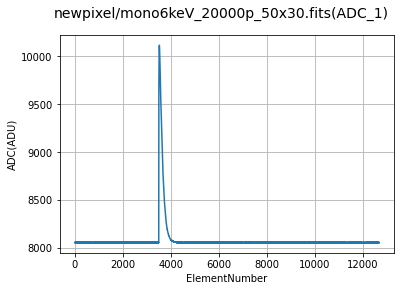

In [27]:
file = fits.open(templateRecordsFile, memmap=True)
fileTab = file['TESRECORDS'].data
fileADC = fileTab['ADC']
file.close()

fig = plt.figure()
fig.suptitle(templateRecordsFile+'(ADC_1)', fontsize=14)

elementNumber = np.arange(fileADC[0].size)
plt.plot(elementNumber,fileADC[0])
plt.ylabel('ADC(ADU)')
plt.xlabel('ElementNumber')
plt.grid(True)
plt.show()

meanLast1000 = np.mean(fileADC[0][fileADC[0].size-1000:fileADC[0].size])

#fig.savefig(noiseRecordsFile+'_ADC_1.png', dpi=fig.dpi)

## BUILD THE LIBRARY

In [28]:
libraryFile = "newpixel/optimal_filters_6keV_50x30.fits"

largeFilter = 8192 # largest filter to be created (samples); power of 2 smaller filters will also be created

In [30]:
#libraryFile = "newpixel/of_library_8192_Beascode.fits"
#templateRecordsFile = "OF_50x30/generate_optimal_filter_pulse_template_tmp.fits"
if not os.path.isfile(libraryFile):
    comm = ("teslib Recordfile=" + templateRecordsFile +
            " TesEventFile=myLibEvents.fits" +
            " monoenergy=" + str(templateKeV*1e3) +
            " LibraryFile=" + libraryFile +
            " largeFilter=" + str(largeFilter) +
            " NoiseFile=" + noiseSpectrumFile +
            " XMLFile=" + XMLxifusim +
            " preBuffer=y")
    args = shlex.split(comm)
    try:
        print("Running tool TESLIB (building the library):", comm)
        check_call(args, stderr=STDOUT)
    except RuntimeError:
        print("Error running tool TESLIB (building the library):")
        print(comm)
        chdir(cwd)
        rmtree(tmpDir)
        raise

Running tool TESLIB (building the library): teslib Recordfile=newpixel/mono6keV_20000p_50x30.fits TesEventFile=myLibEvents.fits monoenergy=6000.0 LibraryFile=newpixel/optimal_filters_6keV_50x30.fits largeFilter=8192 NoiseFile=newpixel/noise_50x30.fits XMLFile=config_xifu_50x30_v1_20240607.xml preBuffer=y
Running TESLIB
Read file config_xifu_50x30_v1_20240607.xml
Number of pixels after removing overlaps: 0
 
Attention: preBuffer used => Parameters of library filters read from XML file
Attention: preBuffer!=0 for low resolution (filter length 8) but preBuffer=0 is going to be used
Simulating |==================================================| 100.00%
Warning in writeLibrary: Library created without the PRECALWN and PRCLOFWM HDUs (and without the COVARM...rE columns in the LIBRARY HDU)
Elapsed time: 2313.000000


## SIMULATION OF ISOLATED PULSES AT DIFFERENT ENERGIES (5000 pulses)

In [31]:
####################################################################################################################
npulsesi = 5000 # number of simulated pulses 
#npulsesi = 10 # number of simulated pulses
####################################################################################################################
simulationTimei = npulsesi/2.*TsizeTC/samprate #  simulation time (s)

# Energies
E = [0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

### Generate pulses impacts (TESCONSTPILEUP)

In [32]:
for i in E:
    print(i)
    pulsesKeVi = i # (energy for template and then for optimal filter (keV)
    pulsesImpactsFilei = "newpixel/mono" + str(i) + "keV_" + str(npulsesi) + "p_50x30.piximpact" 
        
    if not os.path.isfile(pulsesImpactsFilei):
        comm = ("tesconstpileup PixImpList=" + pulsesImpactsFilei +
                " XMLFile=" + XMLxifusim +
                " timezero=" + str(tstart) +
                " tstop=" + str(simulationTimei+tstart) +
                " offset=-1" +
                " energy=" + str(pulsesKeVi) +
                " pulseDistance=" + str(pulse_distance) +
                " TriggerSize=" + str(TsizeTC) +
                " sample_freq=" + str(samprate) +
                " clobber=yes")
        args = shlex.split(comm)
        try:
            print("Running tool TESCONSTPILEUP (pulses impacts):", comm)
            check_call(args, stderr=STDOUT)
        except RuntimeError:
            print("Error running tool TESCONSTPILEUP (pulses impacts):")
            print(comm)
            chdir(cwd)
            rmtree(tmpDir)
            raise

0.2
Running tool TESCONSTPILEUP (pulses impacts): tesconstpileup PixImpList=newpixel/mono0.2keV_5000p_50x30.piximpact XMLFile=config_xifu_50x30_v1_20240607.xml timezero=0.03 tstop=854.4302187264559 offset=-1 energy=0.2 pulseDistance=20000 TriggerSize=44500 sample_freq=130208.3 clobber=yes
Read file config_xifu_50x30_v1_20240607.xml
Number of pixels after removing overlaps: 0
 
0.5
Running tool TESCONSTPILEUP (pulses impacts): tesconstpileup PixImpList=newpixel/mono0.5keV_5000p_50x30.piximpact XMLFile=config_xifu_50x30_v1_20240607.xml timezero=0.03 tstop=854.4302187264559 offset=-1 energy=0.5 pulseDistance=20000 TriggerSize=44500 sample_freq=130208.3 clobber=yes
Read file config_xifu_50x30_v1_20240607.xml
Number of pixels after removing overlaps: 0
 
1
Running tool TESCONSTPILEUP (pulses impacts): tesconstpileup PixImpList=newpixel/mono1keV_5000p_50x30.piximpact XMLFile=config_xifu_50x30_v1_20240607.xml timezero=0.03 tstop=854.4302187264559 offset=-1 energy=1 pulseDistance=20000 Trigger

### Generate pulses records (XIFUSIM)

In [33]:
for i in E:
    print(i)
    pulsesKeVi = i # (energy for template and then for optimal filter (keV)
    pulsesImpactsFilei = "newpixel/mono" + str(i) + "keV_" + str(npulsesi) + "p_50x30.piximpact"
    pulsesRecordsFilei = "newpixel/mono" + str(i) + "keV_" + str(npulsesi) + "p_50x30.fits" 
        
    if not os.path.isfile(pulsesRecordsFilei):
        comm = ("xifusim PixImpList=" + pulsesImpactsFilei +
                " Streamfile=" + pulsesRecordsFilei +
                " tstart=" + str(tstart) +
                " tstop=" + str(simulationTimei+tstart) +
                " trig_reclength=" + str(TsizeSM) +
                " trig_n_pre=" + str(preBuffer) +
                " trig_n_suppress=" + str(pulse_length) + 
                # En el FITS de configuración del pixel NEW (pars_lpa2.5_int.fits) => MAXRECLE=8192 
                # En el antiguo (config_xifu_50x30_calibrated_EP.fits) => MAXRECLE=100000
                " trig_maxreclength=100000" +   
                " acbias=no" + 
                " simnoise=y" +
                " clobber=yes" +
                " XMLfilename=" + XMLxifusim)
        args = shlex.split(comm)
        try:
            print("Running tool XIFUSIM (pulses records):", comm)
            check_call(args, stderr=STDOUT)
        except RuntimeError:
            print("Error running tool XIFUSIM (pulses records):")
            print(comm)
            chdir(cwd)
            rmtree(tmpDir)
            raise

0.2
Running tool XIFUSIM (pulses records): xifusim PixImpList=newpixel/mono0.2keV_5000p_50x30.piximpact Streamfile=newpixel/mono0.2keV_5000p_50x30.fits tstart=0.03 tstop=854.4302187264559 trig_reclength=12692 trig_n_pre=3500 trig_n_suppress=8192 trig_maxreclength=100000 acbias=no simnoise=y clobber=yes XMLfilename=config_xifu_50x30_v1_20240607.xml

Running xifusim version 0.8.3.37-e5e4-dirty


=== Setup ===

Parameter RECLEN in block Trigger overridden from command line (RECLEN = 12692)
Parameter N_PRE in block Trigger overridden from command line (N_PRE = 3500)
Parameter N_SUPPRE in block Trigger overridden from command line (N_SUPPRE = 8192)
Parameter MAXRECLE in block Trigger overridden from command line (MAXRECLE = 100000)
=== Simulating ===

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
=== Postprocessing ===
0.5
Running tool XIFUSIM (pulses records): xifusim PixImpList

In [34]:
# Check if there is a peak at the beginning of the first record => Increase tstart
for i in E:
    file = fits.open(pulsesRecordsFilei, memmap=True)
    fileTab = file['TESRECORDS'].data
    fileADC = fileTab['ADC']
    file.close()

    meanLast1000 = np.mean(fileADC[0][fileADC[0].size-1000:fileADC[0].size])
    if abs(fileADC[0][1]-meanLast1000)>20:
        print(i, "keV => Peak at the beginning => Increase tstart")

## RECONSTRUCTION OF ISOLATED PULSES AT DIFFERENT ENERGIES (5000 pulses): OF8196 and 0-padding4096

In [35]:
for i in E:
    print(i, "keV")
    pulsesKeVi = i # (energy for template and then for optimal filter (keV)
    pulsesRecordsFilei = "newpixel/mono" + str(i) + "keV_" + str(npulsesi) + "p_50x30.fits" 
    eventsFilei = "newpixel/events_mono" + str(i) + "keV_" + str(npulsesi) + "p_50x30_of8192.fits" 
        
    if not os.path.isfile(eventsFilei):
        comm = ("tesrecons Recordfile=" + pulsesRecordsFilei +
                " TesEventFile=" + eventsFilei +
                " filtEeV=6000.0" +
                " LibraryFile=" + libraryFile +
                " EnergyMethod=OPTFILT" +
                " OFLength=8192 " +
                " OFLengthNotPadded=8192" +
                " OFStrategy=BYGRADE" +
                " prebuffer=yes" +
                " XMLFile=" + XMLxifusim)
        args = shlex.split(comm)
        try:
            print("Running tool TESRECONS (detected events of8192):", comm)
            check_call(args, stderr=STDOUT)
        except RuntimeError:
            print("Error running tool TESRECONS (detected events of8192):")
            print(comm)
            chdir(cwd)
            rmtree(tmpDir)
            raise
            
    eventsFilei = "newpixel/events_mono" + str(i) + "keV_" + str(npulsesi) + "p_50x30_0pad4096.fits" 
        
    if not os.path.isfile(eventsFilei):
        comm = ("tesrecons Recordfile=" + pulsesRecordsFilei +
                " TesEventFile=" + eventsFilei +
                " filtEeV=6000.0" +
                " LibraryFile=" + libraryFile +
                " EnergyMethod=OPTFILT" +
                " OFLength=8192 " +
                " OFLengthNotPadded=4096" +
                " OFStrategy=FIXED" +
                " prebuffer=yes" +
                " XMLFile=" + XMLxifusim)
        args = shlex.split(comm)
        try:
            print("Running tool TESRECONS (detected events 0pad4096):", comm)
            check_call(args, stderr=STDOUT)
        except RuntimeError:
            print("Error running tool TESRECONS (detected events 0pad4096):")
            print(comm)
            chdir(cwd)
            rmtree(tmpDir)
            raise
            

0.2 keV
Running tool TESRECONS (detected events of8192): tesrecons Recordfile=newpixel/mono0.2keV_5000p_50x30.fits TesEventFile=newpixel/events_mono0.2keV_5000p_50x30_of8192.fits filtEeV=6000.0 LibraryFile=newpixel/optimal_filters_6keV_50x30.fits EnergyMethod=OPTFILT OFLength=8192  OFLengthNotPadded=8192 prebuffer=yes XMLFile=config_xifu_50x30_v1_20240607.xml
Running TESRECONS
Read file config_xifu_50x30_v1_20240607.xml
Number of pixels after removing overlaps: 0
 
Attention: preBuffer used => Parameters of library filters read from XML file
Attention: preBuffer!=0 for low resolution (filter length 8) but preBuffer=0 is going to be used
Warning in runEnergy: There are no valid pulses detected in record 4%
Warning in runEnergy: There are no valid pulses detected in record 7%
Warning in runEnergy: There are no valid pulses detected in record 36
Warning in runEnergy: There are no valid pulses detected in record 43
Warning in runEnergy: There are no valid pulses detected in record 46
Warni

## SIMULATION OF PAIRS OF PULSES AT DIFFERENT ENERGIES AND SEPARATIONS (2000 pairs of pulses)

In [36]:
# Function to generate separations logarithmically spaced
def logspace(start, end, num):
    log_values = np.logspace(np.log10(start), np.log10(end), num)
    integer_values = [int(value) for value in log_values]
    return integer_values

# Lower separation, higher separation and desired number of separations
#start = 4.0
start = 8.0
end = 2000.0
num = 20

# Generate the values
separation = logspace(start, end, num)

# Print separation
print(separation)

[4, 5, 7, 10, 14, 20, 28, 39, 54, 75, 105, 146, 202, 281, 389, 540, 749, 1039, 1442, 2000]


In [ ]:
####################################################################################################################
npairsi = 2000 # number of pairs simulated pulses 
#npairsi = 10 # number of pairs simulated pulses
####################################################################################################################
#simulationTimei = npairsi/2.*TsizeTC/samprate #  simulation time (s)

# Energies
Ep = [0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] # Energy of the primary pulses
Es = [0.2, 0.5, 0.8, 1, 1.3, 1.6, 2, 2.3, 2.6, 3, 3.3, 3.6, 4, 4.3, 4.6, 5, 5.3, 5.6, 6, 6.3, 6.6, 7, 7.3, 7.6, 8, 8.3, 8.6, 9, 9.3, 9.6, 10, 10.3, 10.6, 11, 11.3, 11.6, 12] # Energy of the secondary pulses
#Ep = [0.2, 0.5, 1] # Energy of the primary pulses
#Es = [0.2, 0.5, 0.8] # Energy of the secondary pulses
#separation = [10, 100, 1000]

### Generate pairs of pulses impacts (TESCONSTPILEUP)

In [ ]:
for Epi in Ep:
    for Esi in Es:
        for sepi in separation:
            # File names
            root = ("sep" + str(sepi) + "sam_" + str(npairsi) + "p_" + str(Epi) + "keV_" + str(Esi) + "keV")
            print(root)
            pairsImpactsFilei = "newpixel/" + root + "_50x30.piximpact"

            # Simulation time
            TsizeTCi = preBuffer + sepi + recordSeparation + 1000
            #simulationTime= (nSimPulses/2)recs * (triggerSize sam/rec)/(samprate sam/s)
            simulationTimei = npairsi * int(TsizeTCi) / samprate
            #simTime = '{0:0.0f}'.format(simulationTimei)

            if not os.path.isfile(pairsImpactsFilei):
                comm = ("tesconstpileup PixImpList=" + pairsImpactsFilei +
                    " XMLFile=" + XMLxifusim +
                    " timezero=" + str(tstart) +
                    " tstop=" + str(simulationTimei+tstart) +
                    " offset=-1" +
                    " energy=" + str(Epi) +
                    " energy2=" + str(Esi) +
                    " pulseDistance=" + str(sepi) +
                    " TriggerSize=" + str(TsizeTCi) +
                    " sample_freq=" + str(samprate) +
                    " clobber=yes")
                args = shlex.split(comm)
                try:
                    print("Running tool TESCONSTPILEUP (pairs of pulses impacts):", comm)
                    check_call(args, stderr=STDOUT)
                except RuntimeError:
                    print("Error running tool TESCONSTPILEUP (pairs of pulses impacts):")
                    print(comm)
                    chdir(cwd)
                    rmtree(tmpDir)
                    raise

    
#TsizeTC = preBuffer+pulse_distance+recordSeparation+1000 # simulated double-pulse record length (samples)
#TsizeSM = preBuffer+pulse_length+1000 # trigger (isolated pulse) record length 

   
# calculate sim time to have at least nSimPulses pulses:
    
    #    triggerSizeXF = preBufferSize + sep12 + pulseLength + 1000
    #    triggerSuppXF = triggerSizeXF - preBufferSize

### Generate pairs of pulses template records (XIFUSIM)

In [40]:
Ep = [0.2]
Es = [0.2]
separation = [4, 5, 7, 10, 14, 20, 28, 39]
for Epi in Ep:
    for Esi in Es:
        for sepi in separation: 
            # File names
            root = ("sep" + str(sepi) + "sam_" + str(npairsi) + "p_" + str(Epi) + "keV_" + str(Esi) + "keV")
            pairsImpactsFilei = "newpixel/" + root + "_50x30.piximpact"
            pairsRecordsFilei = "newpixel/" + root + "_50x30.fits"
                
            # Simulation time
            TsizeTCi = preBuffer + sepi + pulse_distance + recordSeparation + 1000
            #print("TsizeTCi=",TsizeTCi)
            #simulationTime= (nSimPulses/2)recs * (triggerSize sam/rec)/(samprate sam/s)
            simulationTimei = npairsi * TsizeTCi / samprate
            #print("simulationTimei=",simulationTimei)
            #simTime = '{0:0.0f}'.format(simulationTimei)
            TsizeSMi = preBuffer + sepi + pulse_length + 1000
            #print("TsizeSMi=",TsizeSMi)
            
            if not os.path.isfile(pairsRecordsFilei):
                comm = ("xifusim PixImpList=" + pairsImpactsFilei +
                        " Streamfile=" + pairsRecordsFilei +
                        " tstart=" + str(tstart) +
                        " tstop=" + str(simulationTimei+tstart) +
                        " trig_reclength=" + str(TsizeSMi) +
                        " trig_n_pre=" + str(preBuffer) +
                        " trig_n_suppress=" + str(pulse_length) + 
                        # En el FITS de configuración del pixel NEW (pars_lpa2.5_int.fits) => MAXRECLE=8192 
                        # En el antiguo (config_xifu_50x30_calibrated_EP.fits) => MAXRECLE=100000
                        " trig_maxreclength=100000" +   
                        " acbias=no" + 
                        " simnoise=y" +
                        " clobber=yes" +
                        " XMLfilename=" + XMLxifusim)
                args = shlex.split(comm)
                try:
                    print("Running tool XIFUSIM (pairs of pulses records):", comm)
                    check_call(args, stderr=STDOUT)
                except RuntimeError:
                    print("Error running tool XIFUSIM (pairs of pulses records):")
                    print(comm)
                    chdir(cwd)
                    rmtree(tmpDir)
                    raise 

            # Check if there is a peak at the beginning of the first record => Increase tstart
            file = fits.open(pairsRecordsFilei, memmap=True)
            fileTab = file['TESRECORDS'].data
            fileADC = fileTab['ADC']
            file.close()

            meanLast1000 = np.mean(fileADC[0][fileADC[0].size-1000:fileADC[0].size])
            if abs(fileADC[0][1]-meanLast1000)>20:
                print(i, "keV => Peak at the beginning => Increase tstart")
        

TsizeTCi= 44504
simulationTimei= 1708.9540374922335
TsizeSMi= 12696
TsizeTCi= 44505
simulationTimei= 1708.992437502064
TsizeSMi= 12697
TsizeTCi= 44507
simulationTimei= 1709.0692375217247
TsizeSMi= 12699
TsizeTCi= 44510
simulationTimei= 1709.184437551216
TsizeSMi= 12702
TsizeTCi= 44514
simulationTimei= 1709.3380375905376
TsizeSMi= 12706
TsizeTCi= 44520
simulationTimei= 1709.56843764952
TsizeSMi= 12712
TsizeTCi= 44528
simulationTimei= 1709.8756377281632
TsizeSMi= 12720
TsizeTCi= 44539
simulationTimei= 1710.2980378362977
TsizeSMi= 12731


## RECONSTRUCTION OF PAIRS OF PULSES AT DIFFERENT ENERGIES AND SEPARATIONS (2000 pairs of pulses): OF8196 and 0-padding4096

In [ ]:
for Epi in Ep:
    for Esi in Es:
        for sepi in separation: 
            # File names
            root = ("sep" + str(sepi) + "sam_" + str(npairsi) + "p_" + str(Epi) + "keV_" + str(Esi) + "keV")
            print(root)
            pairsRecordsFilei = "newpixel/" + root + "_50x30.fits"
            eventsFilei = "newpixel/" + "events_" + root + "_50x30_of8192.fits" 
        
            if not os.path.isfile(eventsFilei):
                print("OPTFILT8192")
                comm = ("tesrecons Recordfile=" + pairsRecordsFilei +
                        " TesEventFile=" + eventsFilei +
                        " filtEeV=6000.0" +
                        " LibraryFile=" + libraryFile +
                        " EnergyMethod=OPTFILT" +
                        " OFLength=8192 " +
                        " OFLengthNotPadded=8192" +
                        " OFStrategy=BYGRADE" +
                        " prebuffer=yes" +
                        " XMLFile=" + XMLxifusim)
                args = shlex.split(comm)
                try:
                    print("Running tool TESRECONS (detected events of8192):", comm)
                    check_call(args, stderr=STDOUT)
                except RuntimeError:
                    print("Error running tool TESRECONS (detected events of8192):")
                    print(comm)
                    chdir(cwd)
                    rmtree(tmpDir)
                    raise

            eventsFilei = "newpixel/" + "events_" + root + "_50x30_0pad4096.fits" 
                
            if not os.path.isfile(eventsFilei):
                print("0PAD4096")
                comm = ("tesrecons Recordfile=" + pairsRecordsFilei +
                        " TesEventFile=" + eventsFilei +
                        " filtEeV=6000.0" +
                        " LibraryFile=" + libraryFile +
                        " EnergyMethod=OPTFILT" +
                        " OFLength=8192 " +
                        " OFLengthNotPadded=4096" +
                        " OFStrategy=FIXED" +
                        " prebuffer=yes" +
                        " XMLFile=" + XMLxifusim)
                args = shlex.split(comm)
                try:
                    print("Running tool TESRECONS (detected events 0pad4096):", comm)
                    check_call(args, stderr=STDOUT)
                except RuntimeError:
                    print("Error running tool TESRECONS (detected events 0pad4096):")
                    print(comm)
                    chdir(cwd)
                    rmtree(tmpDir)
                    raise

sep4sam_5000p_0.2keV_0.2keV
OPTFILT8192
Running tool TESRECONS (detected events of8192): tesrecons Recordfile=newpixel/sep4sam_5000p_0.2keV_0.2keV_50x30.fits TesEventFile=newpixel/events_sep4sam_5000p_0.2keV_0.2keV_50x30_of8192.fits filtEeV=6000.0 LibraryFile=newpixel/optimal_filters_6keV_50x30.fits EnergyMethod=OPTFILT OFLength=8192  OFLengthNotPadded=8192 OFStrategy = BYGRADE prebuffer=yes XMLFile=config_xifu_50x30_v1_20240607.xml
Running TESRECONS
Read file config_xifu_50x30_v1_20240607.xml
Number of pixels after removing overlaps: 0
 
Attention: preBuffer used => Parameters of library filters read from XML file
Attention: preBuffer!=0 for low resolution (filter length 8) but preBuffer=0 is going to be used
Simulating |==================================================| 100.00%
Elapsed time: 547.000000
0PAD4096
Running tool TESRECONS (detected events 0pad4096): tesrecons Recordfile=newpixel/sep4sam_5000p_0.2keV_0.2keV_50x30.fits TesEventFile=newpixel/events_sep4sam_5000p_0.2keV_0.2k